In [19]:
from transformers import pipeline
import torch
import os

import seaborn as sns
import matplotlib.pyplot as plt
from src.metrics import compute_score
from src.generate import model_evaluation
from scipy.stats import pearsonr

OUTPUT_FOLDER = "output/samples/en/phase_1/model/base_prompt/zero_shot"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    
# model_id = "meta-llama/Llama-3.2-3B-Instruct"
model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    # device="cuda",
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use cuda:0


In [20]:
model_evaluation(pipe, clinical_case="He is sick and has headache and a fever", discharge_summary="He is sick and a fever", filenames=[])



No human evaluation file provided. Skipping example generation.




{'Content Relevance': 2,
 'Information Completeness': 2,
 'Clarity and Structure': 2,
 'Content Accuracy': 3,
 'Hallucinations': 4,
 'Impact of Hallucinations': 3,
 'Relevance to Practice': 2,
 'Overall Quality': 2,
 'Positive/Negative highlights of generation process': 'Summary lacks key details',
 'Other comments on Generated/Original data sources': 'Original data lacks diagnoses and treatments'}

In [21]:
# Evaluate phase 1 data
from src.data import files_to_df
import os

data_path = "output/samples/en/phase_1/"
k_shot_filenames = []
eval_filenames = ["34530632", "32997782", "30785587"]
human_eval_file="output/samples/en/phase_1/human_eval.csv"
base_filenames_path="output/samples/en/phase_1"

sample_df_gen = files_to_df(os.path.join(data_path, "generated"))
sample_df_gen["filenameid"] = sample_df_gen["filenameid"].str.replace("_transformed_step1", "")

sample_df_orig = files_to_df(os.path.join(data_path, "original"))
sample_df = sample_df_orig.merge(sample_df_gen, on="filenameid", suffixes=("_orig", "_gen"))

sample_df = sample_df[sample_df["filenameid"].isin(eval_filenames)]
sample_df

,filenameid,text_orig,text_gen
0,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...
3,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...
4,30785587,"A 51-year-old male, hypertensive patient, a fo...",**Discharge Summary**\n\n**Patient Information...


In [22]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

filenames = []
d_gen = sample_df.progress_apply(lambda x: model_evaluation(pipe, x["text_orig"], x["text_gen"], k_shot_filenames, "hf", human_eval_file=human_eval_file, base_filenames_path=base_filenames_path),
                                    axis=1)


100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


In [23]:
df_metrics = pd.DataFrame(d_gen.tolist(), index=sample_df.index)
df_model_eval = pd.concat([sample_df, df_metrics], axis=1)
df_model_eval

,filenameid,text_orig,text_gen,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive/Negative highlights of generation process,Other comments on Generated/Original data sources
0,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...,4,3,2,3,5,5,2,2,The discharge summary provided a comprehensive...,The original clinical case and discharge summa...
3,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...,4,4,4,4,2,3,4,4,The generated discharge summary accurately ref...,The generated discharge summary was comparable...
4,30785587,"A 51-year-old male, hypertensive patient, a fo...",**Discharge Summary**\n\n**Patient Information...,4,5,3,4,2,4,2,3,The generated discharge summary was generally ...,The original clinical case and discharge summa...


In [24]:
df_model_eval.to_csv(os.path.join(OUTPUT_FOLDER, "model_evaluation.csv"), index=False)

# Load Human Evaluation

In [25]:
he_path = "output/samples/en/phase_1/human_eval.csv"
df_human_eval = pd.read_csv(he_path)
df_human_eval = df_human_eval.iloc[:, 2:]
df_human_eval.columns = ["filenameid", 'Content Relevance', 'Information Completeness', 'Clarity and Structure', 'Content Accuracy',\
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice', 'Overall Quality',\
       'Positive highlights of generation process', 'Negative highlights of generation process', 'Other comments on Generated/Original data sources'\
       ]
df_human_eval["filenameid"] = df_human_eval["filenameid"].astype(str) 
df_human_eval = df_human_eval[df_human_eval["filenameid"].isin(eval_filenames)]
df_human_eval

,filenameid,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights of generation process,Negative highlights of generation process,Other comments on Generated/Original data sources
1,34530632,5,4,5,5,1,1,5,4,Very good performance in general.,"Lack of some information e.g., desfibrillator ...",NaN
2,32997782,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",NaN
4,30785587,1,1,2,2,1,1,1,2,NaN,Too much information omitted and the text is o...,NaN


In [26]:
auto_path = "output/samples/en/phase_1/phase_1.csv"
df_auto = pd.read_csv(auto_path).rename(columns={"filename": "filenameid"})
df_auto["filenameid"] = df_auto["filenameid"].astype(str)
df_auto = df_auto.drop(columns=["cluster"])
df_auto = df_auto[df_auto["filenameid"].isin(eval_filenames)]
df_auto.dtypes

filenameid     object
precision     float64
recall        float64
f1            float64
tp              int64
fp              int64
fn              int64
dtype: object

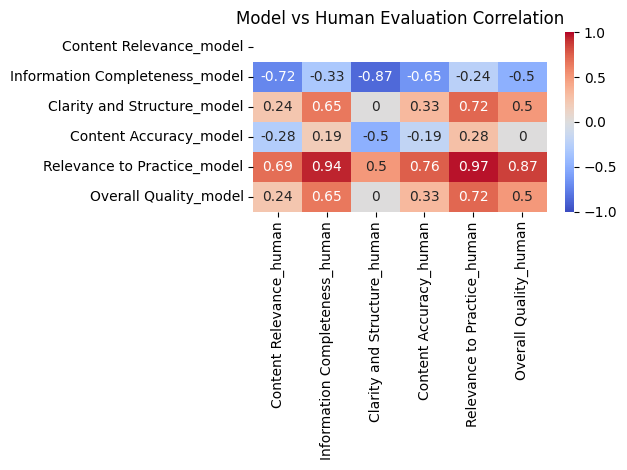

In [27]:
df_total = df_model_eval.merge(df_human_eval, on="filenameid", suffixes=("_model", "_human"))
df_total = df_total.merge(df_auto, on="filenameid")
df_total_num = df_total.select_dtypes(int)

nan_cols = ["Hallucinations_model", "Impact of Hallucinations_model", "Hallucinations_human", "Impact of Hallucinations_human"]

human_cols = [col for col in df_total_num.columns if "human" in col and col not in nan_cols]
model_cols = [col for col in df_total_num.columns if "model" in col and col not in nan_cols]

model_human_corr = df_total_num.corr().loc[model_cols, human_cols]

sns.heatmap(model_human_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Model vs Human Evaluation Correlation");
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "model_human_corr.png"), dpi=300)

In [28]:
pearsonr(df_total["Overall Quality_model"], df_total["Overall Quality_human"])

PearsonRResult(statistic=0.4999999999999999, pvalue=0.6666666666666667)

# Auto Evaluation

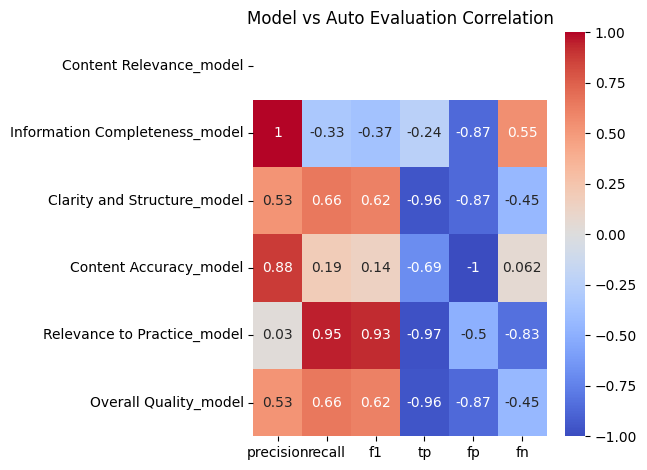

In [29]:
import numpy as np

auto_cols = df_auto.select_dtypes(np.number).columns

model_auto_corr = df_total.select_dtypes(np.number).corr().loc[model_cols, auto_cols]

sns.heatmap(model_auto_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Model vs Auto Evaluation Correlation");

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "model_auto_corr.png"), dpi=300)

In [30]:
pearsonr(df_total["f1"], df_total["Overall Quality_model"])

PearsonRResult(statistic=0.6170461357921865, pvalue=0.576658365896219)

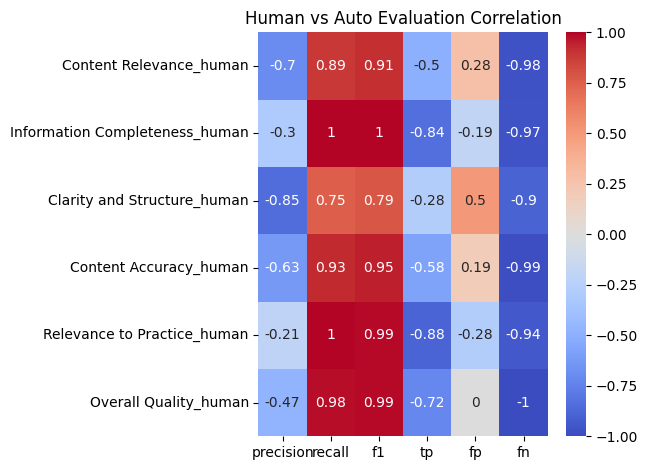

In [31]:
# Now human versus auto

human_auto_corr = df_total.select_dtypes(np.number).corr().loc[human_cols, auto_cols]

sns.heatmap(human_auto_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Human vs Auto Evaluation Correlation");

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "human_auto_corr.png"), dpi=300)

In [32]:
from scipy.stats import pearsonr
def compute_score(df_auto, df_human, col_auto, col_human):
    return pearsonr(df_auto[col_auto], df_human[col_human])

compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_human")

PearsonRResult(statistic=0.9900218204466373, pvalue=0.09000830077044823)

In [33]:
compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_model")

PearsonRResult(statistic=0.6170461357921865, pvalue=0.576658365896219)

In [34]:
compute_score(df_total, df_total, col_auto="Overall Quality_human", col_human="Overall Quality_model")

PearsonRResult(statistic=0.4999999999999999, pvalue=0.6666666666666667)

# Metrics

In [35]:
pearson_auto_human = compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_human")
pearson_auto_model = compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_model")
pearson_human_model = compute_score(df_total, df_total, col_auto="Overall Quality_human", col_human="Overall Quality_model")

df_metrics_pearson = pd.DataFrame([pearson_auto_human, pearson_auto_model, pearson_human_model], columns=["pearson", "p-value"], index=["auto_human", "auto_model", "human_model"])
df_metrics_pearson.to_csv(os.path.join(OUTPUT_FOLDER, "pearson_metrics.csv"))

In [36]:
df_metrics_pearson

,pearson,p-value
auto_human,0.990022,0.090008
auto_model,0.617046,0.576658
human_model,0.500000,0.666667
